In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from pyproj import Proj, Transformer
from scipy.interpolate import griddata
import xeofs as xe
from geometry_izzyv1 import grad_sphere
from regression_izzyv1 import linregress_3D
import cartopy.crs as ccrs

crs = ccrs.PlateCarree()
import warnings
import os

warnings.filterwarnings('ignore')
from matplotlib.ticker import MultipleLocator


In [61]:
gridtype = 'remapcon'

In [62]:
#open the different datasets/load glacier ice vels
path = '/Users/iw2g24/PycharmProjects/SSH_project/'
print(path)
ds = xr.open_dataset(path + 'Data/dot_all_30bmedian_goco05c_sig3_1.nc')
print(ds)
# ERA5 remap dataset
ds_era5 = xr.open_dataset(path + 'Data/ERA5_u10v10_Antartica_2000-2023_' + gridtype + '.nc')

/Users/iw2g24/PycharmProjects/SSH_project/
<xarray.Dataset> Size: 109MB
Dimensions:          (longitude: 360, latitude: 64, time: 196, edge_lat: 65,
                      edge_lon: 361)
Coordinates:
  * longitude        (longitude) float64 3kB -179.5 -178.5 ... 178.5 179.5
  * latitude         (latitude) float64 512B -81.75 -81.25 ... -50.75 -50.25
  * time             (time) datetime64[ns] 2kB 2002-07-01 ... 2018-10-01
  * edge_lat         (edge_lat) float64 520B -82.0 -81.5 -81.0 ... -50.5 -50.0
  * edge_lon         (edge_lon) float64 3kB -180.0 -179.0 -178.0 ... 179.0 180.0
Data variables:
    dot              (longitude, latitude, time) float64 36MB ...
    ug               (longitude, latitude, time) float64 36MB ...
    vg               (longitude, latitude, time) float64 36MB ...
    land_mask        (longitude, latitude) float64 184kB ...
    intersat_offset  float64 8B ...
Attributes:
    history:      Created 08/01/2022, 00:5223
    description:  ENVISAT + CryoSat2 altimetry 

In [63]:
path = '/Users/iw2g24/PycharmProjects/SSH_project/mca_shared_izzy/'
ice_vels_ds = xr.open_dataset(path+ 'NSIDC-0792_19920317-20171216_V01.0.nc')
print(ice_vels_ds)

regridded_ice_vels_melt = xr.open_dataset(path+ 'regridded_ice_vels_melt.nc')


<xarray.Dataset> Size: 25GB
Dimensions:            (x: 2916, y: 2916, time: 104)
Coordinates:
  * x                  (x) float64 23kB -2.798e+06 -2.796e+06 ... 2.798e+06
  * y                  (y) float64 23kB 2.798e+06 2.796e+06 ... -2.798e+06
  * time               (time) datetime64[ns] 832B 1992-03-17T03:04:19.2000023...
Data variables: (12/16)
    melt               (time, y, x) float32 4GB ...
    melt_mean          (y, x) float32 34MB ...
    melt_err           (time, y, x) float32 4GB ...
    height_change      (time, y, x) float32 4GB ...
    height_change_err  (y, x) float32 34MB ...
    fac                (time, y, x) float32 4GB ...
    ...                 ...
    smb_err            (time, y, x) float32 4GB ...
    thickness          (time, y, x) float32 4GB ...
    thickness_mean     (y, x) float32 34MB ...
    thickness_err      (y, x) float32 34MB ...
    ID                 (y, x) uint8 9MB ...
    crs                |S1 1B ...
Attributes:
    Conventions:   CF-1.6
    da

In [64]:
path = '/Users/iw2g24/PycharmProjects/SSH_project/mca_shared_izzy/'
print(path)
WSC_eumetsat_ds = xr.open_dataset(path + 'WSC_eumetsat_masked_v2.nc')
WSC_nsidc_ds = xr.open_dataset(path + 'WSC_nsidc_masked_v2.nc')
sidc_eumetsat_ds = xr.open_dataset(path + 'sidc_eumetsat_masked_v2.nc')
sidc_nsidc_ds = xr.open_dataset(path + 'sidc_nsidc_masked_v2.nc')
tau_nsidc_ds = xr.open_dataset(path + 'tau_nsidc_ds_v3.nc')
tau_eumetsat_ds = xr.open_dataset(path + 'tau_eumetsat_ds_v3.nc')
dot_masked_ds = xr.open_dataset(path + 'dot_masked_v2.nc')

/Users/iw2g24/PycharmProjects/SSH_project/mca_shared_izzy/


In [65]:
print(dot_masked_ds)

<xarray.Dataset> Size: 36MB
Dimensions:  (time: 196, lat: 64, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lat      (lat) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    SSH      (time, lat, lon) float64 36MB ...


In [66]:
print(ice_vels_ds['melt'].dims)

('time', 'y', 'x')


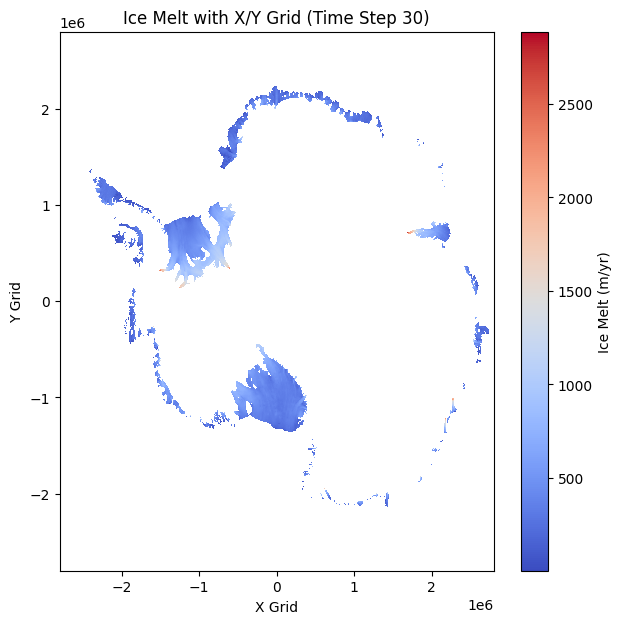

In [67]:
# Select the data for a specific time step
data_to_plot = ice_vels_ds['thickness'].isel(time=30)

# Define color range limits
vmin_value = data_to_plot.values.min()  # Set minimum value for color scale
vmax_value = data_to_plot.values.max()   # Set maximum value for color scale

plt.figure(figsize=(7,7))

# Plot with fixed color limits
mesh = plt.pcolormesh(
    ice_vels_ds["x"],
    ice_vels_ds["y"],
    data_to_plot,
    cmap="coolwarm",
    shading="auto",
    #vmin=vmin_value,  # Set minimum color value
    #vmax=vmax_value   # Set maximum color value
)

# Add colorbar with label
cbar = plt.colorbar(mesh)
cbar.set_label("Ice Melt (m/yr)")

# Titles and labels
plt.title("Ice Melt with X/Y Grid (Time Step 30)")
plt.xlabel("X Grid")
plt.ylabel("Y Grid")

# Show the plot
plt.show()


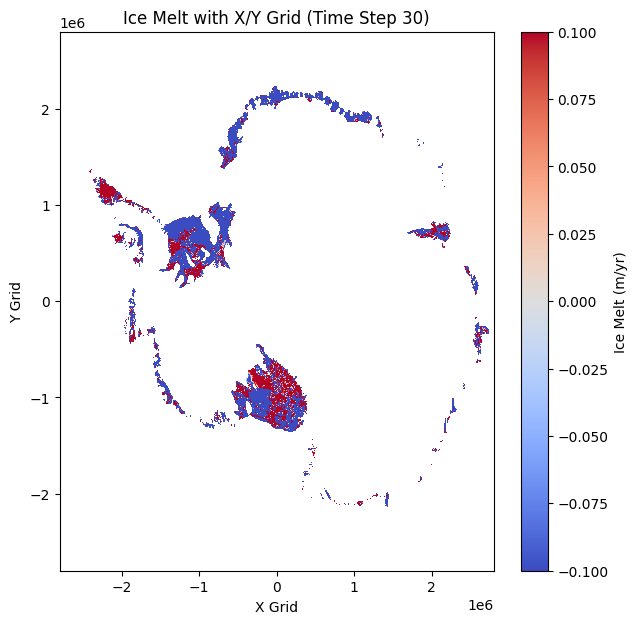

In [68]:
# Select the data for a specific time step
data_to_plot = ice_vels_ds['melt'].isel(time=30)

# Define color range limits
vmin_value = data_to_plot.values.min()  # Set minimum value for color scale
vmax_value = data_to_plot.values.max()   # Set maximum value for color scale

plt.figure(figsize=(7,7))

# Plot with fixed color limits
mesh = plt.pcolormesh(
    ice_vels_ds["x"],
    ice_vels_ds["y"],
    data_to_plot,
    cmap="coolwarm",
    shading="auto",
    vmin=vmin_value,  # Set minimum color value
    vmax=vmax_value   # Set maximum color value
)

# Add colorbar with label
cbar = plt.colorbar(mesh)
cbar.set_label("Ice Melt (m/yr)")

# Titles and labels
plt.title("Ice Melt with X/Y Grid (Time Step 30)")
plt.xlabel("X Grid")
plt.ylabel("Y Grid")

# Show the plot
plt.show()


In [69]:
# change coordinates from (lon,lat,time) to (time,lat,lon) as ERA5
lon_dot = ds['longitude'].values; lat_dot = ds['latitude'].values
dot_all = ds['dot'].values
dot = np.zeros((dot_all.shape[2], dot_all.shape[1], dot_all.shape[0]))
for t in range(0,dot_all.shape[2]):
    for i in range(0,dot_all.shape[1]):
        for j in range(0,dot_all.shape[0]):
            dot[t,i,j] = dot_all[j,i,t].copy()
seamask = dot[0].copy()/dot[0]
seamask[seamask == 0] = np.nan

In [70]:
# time
time_era5 = ds_era5['time'].values
time_dot = ds['time'].values
time_WSC_eumetsat = WSC_eumetsat_ds['time'].values
time_WSC_nsidc = WSC_nsidc_ds['time'].values
time_tau_eumetsat = tau_eumetsat_ds['time'].values
time_tau_nsidc = tau_nsidc_ds['time'].values
time_sidc_eumetsat = sidc_eumetsat_ds['time'].values
time_sidc_nsidc = sidc_nsidc_ds['time'].values

In [71]:
#check all the times
print("dot time", time_dot[0],time_dot[-1])
print("era5 time", time_era5[30],time_era5[225])
print("wsc time eu", time_WSC_eumetsat[0], time_WSC_eumetsat[-1])
print("wsc time ns", time_WSC_nsidc[0], time_WSC_nsidc[-1])
print("tau time eu", time_tau_eumetsat[0], time_tau_eumetsat[-1])
print("tau time ns", time_tau_nsidc[0], time_tau_nsidc[-1])
print("sidc time eu", time_sidc_eumetsat[0], time_sidc_eumetsat[-1])
print("sidc time ns", time_sidc_nsidc[0], time_sidc_nsidc[-1])

start_time = 0
end_time = -1
start_era_time = 30
end_era_time = 225


dot time 2002-07-01T00:00:00.000000000 2018-10-01T00:00:00.000000000
era5 time 2002-07-01T00:00:00.000000000 2018-10-01T00:00:00.000000000
wsc time eu 2002-07-01T00:00:00.000000000 2018-10-01T00:00:00.000000000
wsc time ns 2002-07-01T00:00:00.000000000 2018-10-01T00:00:00.000000000
tau time eu 2002-07-01T00:00:00.000000000 2018-10-01T00:00:00.000000000
tau time ns 2002-07-01T00:00:00.000000000 2018-10-01T00:00:00.000000000
sidc time eu 2002-07-01T00:00:00.000000000 2018-10-01T00:00:00.000000000
sidc time ns 2002-07-01T00:00:00.000000000 2018-10-01T00:00:00.000000000


In [72]:
#need to convert x and y of ice vels to lon and lat

In [73]:
#converting x and y to lat and lon
# Extract x and y coordinates
x = ice_vels_ds['x'].values  # Get NumPy array of x coordinates
y = ice_vels_ds['y'].values  # Get NumPy array of y coordinates

# Create a 2D grid of x and y coordinates
X, Y = np.meshgrid(x, y)

# Define the stereographic projection (SH)
proj_stere = Proj("+proj=stere +lat_0=-90 +lat_ts=-70 +lon_0=0 +k=1 +x_0=0 +y_0=0 +a=6378273 +b=6356889.449 +units=m +no_defs")

# Define target WGS84 projection
proj_wgs84 = Proj("epsg:4326")

# Use Transformer for efficient vectorized transformation
transformer = Transformer.from_proj(proj_stere, proj_wgs84, always_xy=True)

# Convert entire 2D grid of (X, Y) to (lon, lat)
lon, lat = transformer.transform(X, Y)

# Add lat/lon to dataset
ice_vels_ds.coords['lon'] = (('y', 'x'), lon)
ice_vels_ds.coords['lat'] = (('y', 'x'), lat)

print(ice_vels_ds)
print(ice_vels_ds['lon'].max(), ice_vels_ds['lon'].min())
print(ice_vels_ds['lat'].max(), ice_vels_ds['lat'].min())


<xarray.Dataset> Size: 25GB
Dimensions:            (x: 2916, y: 2916, time: 104)
Coordinates:
  * x                  (x) float64 23kB -2.798e+06 -2.796e+06 ... 2.798e+06
  * y                  (y) float64 23kB 2.798e+06 2.796e+06 ... -2.798e+06
  * time               (time) datetime64[ns] 832B 1992-03-17T03:04:19.2000023...
    lon                (y, x) float64 68MB -45.0 -44.98 -44.96 ... 135.0 135.0
    lat                (y, x) float64 68MB -54.59 -54.6 -54.62 ... -54.61 -54.59
Data variables: (12/16)
    melt               (time, y, x) float32 4GB ...
    melt_mean          (y, x) float32 34MB ...
    melt_err           (time, y, x) float32 4GB ...
    height_change      (time, y, x) float32 4GB ...
    height_change_err  (y, x) float32 34MB ...
    fac                (time, y, x) float32 4GB ...
    ...                 ...
    smb_err            (time, y, x) float32 4GB ...
    thickness          (time, y, x) float32 4GB ...
    thickness_mean     (y, x) float32 34MB ...
    thick

In [74]:
print(ice_vels_ds['lat'].dims)


('y', 'x')


In [75]:
print(WSC_eumetsat_ds)
print(ice_vels_ds)

<xarray.Dataset> Size: 36MB
Dimensions:  (time: 196, lat: 64, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lat      (lat) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    WSC      (time, lat, lon) float64 36MB ...
<xarray.Dataset> Size: 25GB
Dimensions:            (x: 2916, y: 2916, time: 104)
Coordinates:
  * x                  (x) float64 23kB -2.798e+06 -2.796e+06 ... 2.798e+06
  * y                  (y) float64 23kB 2.798e+06 2.796e+06 ... -2.798e+06
  * time               (time) datetime64[ns] 832B 1992-03-17T03:04:19.2000023...
    lon                (y, x) float64 68MB -45.0 -44.98 -44.96 ... 135.0 135.0
    lat                (y, x) float64 68MB -54.59 -54.6 -54.62 ... -54.61 -54.59
Data variables: (12/16)
    melt               (time, y, x) float32 4GB ...
    melt_mean          (y, x) float32 34MB ...
    melt

In [76]:
print(len(ice_vels_ds['lat']))
print(len(ice_vels_ds['lon']))

2916
2916


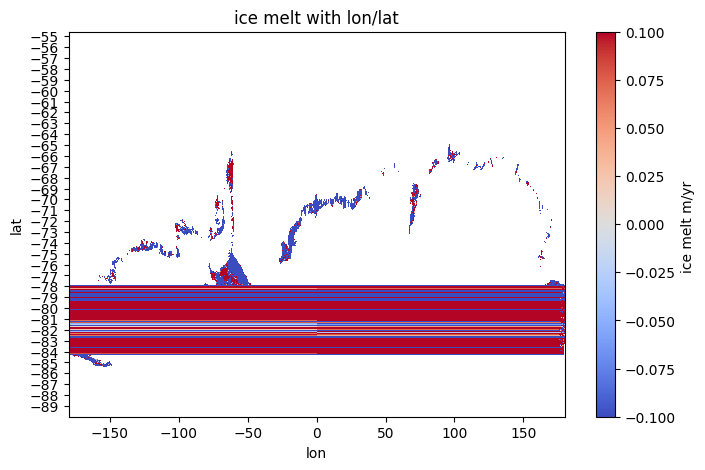

In [77]:
# Plot sea ice drift using lon and lat
data_to_plot = ice_vels_ds['melt'].isel(time=30)

vmin_value = data_to_plot.min()
vmax_value = data_to_plot.max()

plt.figure(figsize=(8,5))
plt.pcolormesh(
    ice_vels_ds["lon"],
    ice_vels_ds["lat"],
    data_to_plot,
    cmap="coolwarm",
    shading="auto",
    vmin=-0.1,
    vmax=0.1,
)
plt.colorbar(label="ice melt m/yr ")
plt.title("ice melt with lon/lat")
plt.xlabel("lon")
plt.ylabel("lat")
plt.gca().yaxis.set_major_locator(MultipleLocator(1))
plt.show()

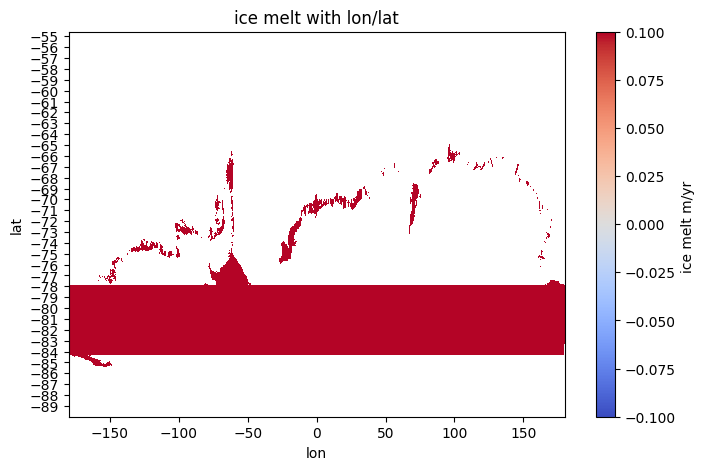

In [78]:
# Plot sea ice drift using lon and lat
data_to_plot = ice_vels_ds['thickness'].isel(time=30)

vmin_value = data_to_plot.min()
vmax_value = data_to_plot.max()

plt.figure(figsize=(8,5))
plt.pcolormesh(
    ice_vels_ds["lon"],
    ice_vels_ds["lat"],
    data_to_plot,
    cmap="coolwarm",
    shading="auto",
    vmin=-0.1,
    vmax=0.1,
)
plt.colorbar(label="ice melt m/yr ")
plt.title("ice melt with lon/lat")
plt.xlabel("lon")
plt.ylabel("lat")
plt.gca().yaxis.set_major_locator(MultipleLocator(1))
plt.show()

In [79]:
#mask ice values with latitudes <-76.7

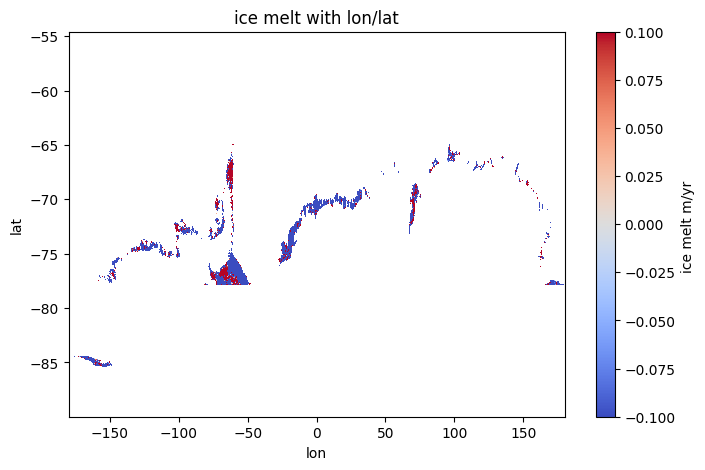

In [80]:
# Plot sea ice drift using x and y coordinates - point at 150,-85 Ross Ice Shelf?
data_to_plot = ice_vels_ds['melt'].isel(time=30)
valid_lat_mask = ~((ice_vels_ds['lat'] > - 84.4) & (ice_vels_ds['lat'] < - 77.84))
masked_data = np.ma.masked_where(~valid_lat_mask, data_to_plot)


vmin_value = data_to_plot.min()
vmax_value = data_to_plot.max()

plt.figure(figsize=(8,5))
plt.pcolormesh(
    ice_vels_ds["lon"],
    ice_vels_ds["lat"],
    masked_data,
    cmap="coolwarm",
    shading="auto",
    vmin=-0.1,
    vmax=0.1,
)
plt.colorbar(label="ice melt m/yr ")
plt.title("ice melt with lon/lat")
plt.xlabel("lon")
plt.ylabel("lat")
plt.gca().yaxis.set_major_locator(MultipleLocator(5))
plt.show()

In [81]:
# Apply the mask to all variables
# for var in ice_vels_ds.data_vars:
#     ice_vels_ds[var] = ice_vels_ds[var].where(valid_lat_mask)

#apply mask to melt
masked_melt = ice_vels_ds['melt'].where(valid_lat_mask)



In [82]:
print(masked_melt['lat'].values.min())

-89.9875653711519


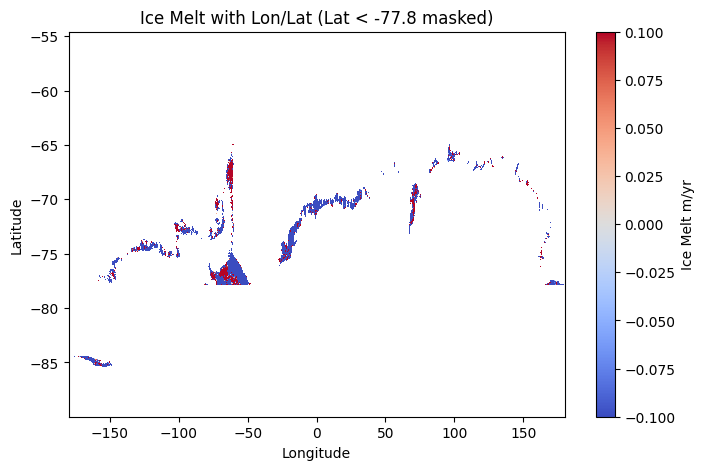

In [83]:
# Plot the masked melt data for a specific time step (e.g., time=30)
plt.figure(figsize=(8, 5))
plt.pcolormesh(
    ice_vels_ds["lon"],
    ice_vels_ds["lat"],
    masked_melt.isel(time=30),  # Plot the melt data at time step 30
    cmap="coolwarm",
    shading="auto",
    vmin=-0.1,
    vmax=0.1
)
plt.colorbar(label="Ice Melt m/yr")
plt.title("Ice Melt with Lon/Lat (Lat < -77.8 masked)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Adjust y-axis ticks
plt.gca().yaxis.set_major_locator(MultipleLocator(5))

# Show the plot
plt.show()


In [84]:
# # Plot the masked melt data for a specific time step (e.g., time=30)
# plt.figure(figsize=(10, 8))
# lon_min = -100
# lon_max = 0
#
# # Create a mask for lon values between lon_min and lon_max
# valid_lon_mask = (ice_vels_ds['lon'] >= lon_min) & (ice_vels_ds['lon'] <= lon_max)
#
# masked_melt = ice_vels_ds["melt"].where(valid_lon_mask)
# masked_lon = ice_vels_ds["lon"].where(valid_lon_mask)
# masked_lat = ice_vels_ds["lat"].where(valid_lon_mask)


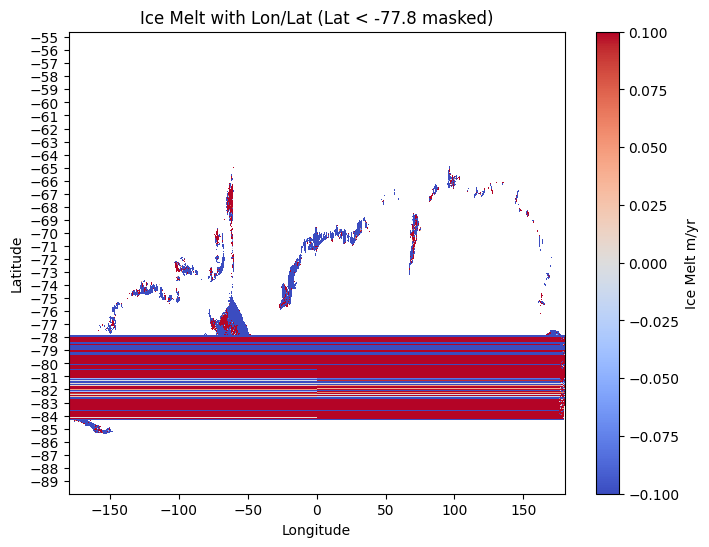

In [85]:
plt.figure(figsize=(8, 6))
plt.pcolormesh(
    ice_vels_ds["lon"],
    ice_vels_ds["lat"],
    ice_vels_ds['melt'].isel(time=30),  # Plot the melt data at time step 30
    cmap="coolwarm",
    shading="auto",
    vmin=-0.1,
    vmax=0.1
)
plt.colorbar(label="Ice Melt m/yr")
plt.title("Ice Melt with Lon/Lat (Lat < -77.8 masked)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")


# Adjust y-axis ticks
plt.gca().yaxis.set_major_locator(MultipleLocator(1))

# Show the plot
plt.show()

In [86]:
print(ice_vels_ds['melt'].shape)
print(dot_masked_ds['SSH'].shape)
print(WSC_eumetsat_ds['WSC'].shape)

(104, 2916, 2916)
(196, 64, 360)
(196, 64, 360)


In [87]:
print(ice_vels_ds['time'])
print(dot_masked_ds['time'][185])

<xarray.DataArray 'time' (time: 104)> Size: 832B
array(['1992-03-17T03:04:19.200002304', '1992-06-16T15:04:19.200002304',
       '1992-09-16T03:04:19.200002304', '1992-12-16T15:04:19.200002304',
       '1993-03-17T22:04:48.000003584', '1993-06-17T04:04:48.000003584',
       '1993-09-16T10:04:48.000003584', '1993-12-16T16:04:48.000003584',
       '1994-03-17T22:04:48.000003584', '1994-06-17T04:04:48.000003584',
       '1994-09-16T10:04:48.000003584', '1994-12-16T16:04:48.000003584',
       '1995-03-17T22:04:48.000003584', '1995-06-17T04:04:48.000003584',
       '1995-09-16T10:04:48.000003584', '1995-12-16T16:04:48.000003584',
       '1996-03-17T03:04:19.200002304', '1996-06-16T15:04:19.200002304',
       '1996-09-16T03:04:19.200002304', '1996-12-16T15:04:19.200002304',
       '1997-03-17T22:04:48.000003584', '1997-06-17T04:04:48.000003584',
       '1997-09-16T10:04:48.000003584', '1997-12-16T16:04:48.000003584',
       '1998-03-17T22:04:48.000003584', '1998-06-17T04:04:48.000003584',
  

In [88]:
print(ice_vels_ds['time'][13])

<xarray.DataArray 'time' ()> Size: 8B
array('1995-06-17T04:04:48.000003584', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 1995-06-17T04:04:48.000003584
Attributes:
    standard_name:  time
    long_name:      time in days since 1950-1-1


In [89]:
# Assuming masked_melt['time'] is a pandas DatetimeIndex or numpy datetime64 array
times = pd.to_datetime(ice_vels_ds['time'].values)  # Convert to pandas datetime if it's not already

# Format to YYYY-MM-01THH:MM:SS., explicitly set day to '01' in the string
formatted_times = times.strftime('%Y-%m-01T00:00:00.000000000')

# Extract nanoseconds directly from pandas Timestamps using .nanosecond
#nanoseconds = masked_melt_times.nanosecond.astype(str).str.zfill(9)

# Combine the formatted time with the nanoseconds to preserve nanosecond precision
formatted_times_with_nano = formatted_times

# Update the 'time' field in masked_melt with the newly formatted time strings
ice_vels_ds['time'] = formatted_times_with_nano

# Print the updated time values
print(ice_vels_ds['time'])
print(ice_vels_ds)


<xarray.DataArray 'time' (time: 104)> Size: 832B
array(['1992-03-01T00:00:00.000000000', '1992-06-01T00:00:00.000000000',
       '1992-09-01T00:00:00.000000000', '1992-12-01T00:00:00.000000000',
       '1993-03-01T00:00:00.000000000', '1993-06-01T00:00:00.000000000',
       '1993-09-01T00:00:00.000000000', '1993-12-01T00:00:00.000000000',
       '1994-03-01T00:00:00.000000000', '1994-06-01T00:00:00.000000000',
       '1994-09-01T00:00:00.000000000', '1994-12-01T00:00:00.000000000',
       '1995-03-01T00:00:00.000000000', '1995-06-01T00:00:00.000000000',
       '1995-09-01T00:00:00.000000000', '1995-12-01T00:00:00.000000000',
       '1996-03-01T00:00:00.000000000', '1996-06-01T00:00:00.000000000',
       '1996-09-01T00:00:00.000000000', '1996-12-01T00:00:00.000000000',
       '1997-03-01T00:00:00.000000000', '1997-06-01T00:00:00.000000000',
       '1997-09-01T00:00:00.000000000', '1997-12-01T00:00:00.000000000',
       '1998-03-01T00:00:00.000000000', '1998-06-01T00:00:00.000000000',
  

In [90]:
time_era5 = ds_era5['time'].values
time_dot = ds['time'].values
time_melt = ice_vels_ds['time'].values
time_WSC = WSC_eumetsat_ds['WSC'].time.values

In [91]:
print(time_era5[0])
print(time_dot[2])
print(time_melt[5])


2000-01-01T00:00:00.000000000
2002-09-01T00:00:00.000000000
1993-06-01T00:00:00.000000000


In [92]:
# Convert lists to pandas datetime objects
time_dot = pd.to_datetime(time_dot)
time_melt = pd.to_datetime(time_melt)
time_era5 = pd.to_datetime(time_era5)
time_WSC = pd.to_datetime(time_WSC)

print(time_era5[32])

# Find the indices where time_melt is in time_dot
indices_dot_melt = np.where(time_melt.isin(time_dot))[0]
print(indices_dot_melt)
indices_melt_in_dot = np.where(time_dot.isin(time_melt))[0]
print(indices_melt_in_dot)
indices_melt_in_era5 = np.where(time_era5.isin(time_melt))[0]
print(indices_melt_in_era5)


2002-09-01 00:00:00
[ 42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103]
[  2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53
  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 101 104 107
 110 113 116 119 122 125 128 131 134 137 140 143 146 149 152 155 158 161
 164 167 170 173 176 179 182 185]
[  2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53
  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 101 104 107
 110 113 116 119 122 125 128 131 134 137 140 143 146 149 152 155 158 161
 164 167 170 173 176 179 182 185 188 191 194 197 200 203 206 209 212 215]


In [93]:
selected_times_dot = time_dot[2:183]
selected_times_era5 = time_era5[32:213]
selected_times_melt = time_melt[42:103]
selected_times_wsc = time_WSC[2:-13]

print(selected_times_dot.min(), selected_times_dot.max())
print(selected_times_era5.min(), selected_times_era5.max())
print(selected_times_melt.min(), selected_times_melt.max())
print(selected_times_wsc.min(), selected_times_wsc.max())

print(selected_times_era5.dtype)


2002-09-01 00:00:00 2017-09-01 00:00:00
2002-09-01 00:00:00 2017-09-01 00:00:00
2002-09-01 00:00:00 2017-09-01 00:00:00
2002-09-01 00:00:00 2017-09-01 00:00:00
datetime64[ns]


In [94]:
print(WSC_eumetsat_ds['WSC'].time[2])
print(WSC_eumetsat_ds['WSC'].time[-1])

<xarray.DataArray 'time' ()> Size: 8B
array('2002-09-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2002-09-01
<xarray.DataArray 'time' ()> Size: 8B
array('2018-10-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2018-10-01


In [95]:
print(ice_vels_ds['time'].min(), ice_vels_ds['time'].max())
print(selected_times_melt.min(), selected_times_melt.max())
print(len(ice_vels_ds['time']))

<xarray.DataArray 'time' ()> Size: 8B
array('1992-03-01T00:00:00.000000000', dtype=object) <xarray.DataArray 'time' ()> Size: 8B
array('2017-12-01T00:00:00.000000000', dtype=object)
2002-09-01 00:00:00 2017-09-01 00:00:00
104


In [96]:
#change time format
selected_times_melt_edit= selected_times_melt.strftime('%Y-%m-01T00:00:00.000000000')
# selected_times_wsc = selected_times_wsc.strftime('%Y-%m-%dT00:00:00.000000000')
# selected_times_dot = selected_times_dot.strftime('%Y-%m-%dT00:00:00.000000000')
print(selected_times_melt_edit)




Index(['2002-09-01T00:00:00.000000000', '2002-12-01T00:00:00.000000000',
       '2003-03-01T00:00:00.000000000', '2003-06-01T00:00:00.000000000',
       '2003-09-01T00:00:00.000000000', '2003-12-01T00:00:00.000000000',
       '2004-03-01T00:00:00.000000000', '2004-06-01T00:00:00.000000000',
       '2004-09-01T00:00:00.000000000', '2004-12-01T00:00:00.000000000',
       '2005-03-01T00:00:00.000000000', '2005-06-01T00:00:00.000000000',
       '2005-09-01T00:00:00.000000000', '2005-12-01T00:00:00.000000000',
       '2006-03-01T00:00:00.000000000', '2006-06-01T00:00:00.000000000',
       '2006-09-01T00:00:00.000000000', '2006-12-01T00:00:00.000000000',
       '2007-03-01T00:00:00.000000000', '2007-06-01T00:00:00.000000000',
       '2007-09-01T00:00:00.000000000', '2007-12-01T00:00:00.000000000',
       '2008-03-01T00:00:00.000000000', '2008-06-01T00:00:00.000000000',
       '2008-09-01T00:00:00.000000000', '2008-12-01T00:00:00.000000000',
       '2009-03-01T00:00:00.000000000', '2009-06-01

In [97]:
print(selected_times_dot[-1])
print(dot_masked_ds['time'][2])
print(selected_times_melt[-1])
print(ice_vels_ds['time'][0])
print(len(ice_vels_ds['time']))
print(len(selected_times_melt_edit))


2017-09-01 00:00:00
<xarray.DataArray 'time' ()> Size: 8B
array('2002-09-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2002-09-01
2017-09-01 00:00:00
<xarray.DataArray 'time' ()> Size: 116B
array('1992-03-01T00:00:00.000000000', dtype='<U29')
Coordinates:
    time     <U29 116B '1992-03-01T00:00:00.000000000'
104
61


In [98]:
selected_SSH = dot_masked_ds['SSH'].sel(time = np.isin(dot_masked_ds['time'].values, selected_times_melt))
selected_WSC = WSC_eumetsat_ds['WSC'].sel(time = np.isin(WSC_eumetsat_ds['time'].values ,selected_times_melt))
selected_ice_vels = masked_melt.sel(time= np.isin(ice_vels_ds['time'].values, selected_times_melt_edit))

print(selected_SSH.shape)
print(selected_WSC.shape)
#print(selected_SSH['time'].min(), selected_SSH['time'].max())
print(selected_ice_vels.shape)
print(ice_vels_ds['lat'].shape)


(61, 64, 360)
(61, 64, 360)
(61, 2916, 2916)
(2916, 2916)


In [99]:
print(dot_masked_ds['lat'])

<xarray.DataArray 'lat' (lat: 64)> Size: 512B
array([-81.75, -81.25, -80.75, -80.25, -79.75, -79.25, -78.75, -78.25, -77.75,
       -77.25, -76.75, -76.25, -75.75, -75.25, -74.75, -74.25, -73.75, -73.25,
       -72.75, -72.25, -71.75, -71.25, -70.75, -70.25, -69.75, -69.25, -68.75,
       -68.25, -67.75, -67.25, -66.75, -66.25, -65.75, -65.25, -64.75, -64.25,
       -63.75, -63.25, -62.75, -62.25, -61.75, -61.25, -60.75, -60.25, -59.75,
       -59.25, -58.75, -58.25, -57.75, -57.25, -56.75, -56.25, -55.75, -55.25,
       -54.75, -54.25, -53.75, -53.25, -52.75, -52.25, -51.75, -51.25, -50.75,
       -50.25])
Coordinates:
  * lat      (lat) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25


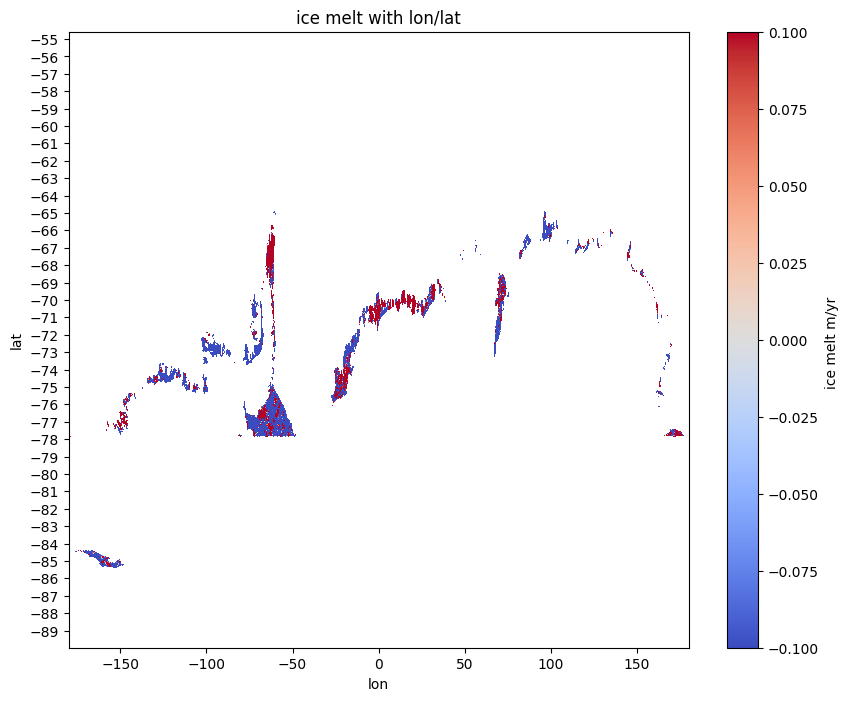

In [100]:
# Plot sea ice drift using lon and lat
data_to_plot = selected_ice_vels.isel(time=30)

vmin_value = data_to_plot.min()
vmax_value = data_to_plot.max()

plt.figure(figsize=(10,8))
plt.pcolormesh(
    ice_vels_ds["lon"],
    ice_vels_ds["lat"],
    data_to_plot,
    cmap="coolwarm",
    shading="auto",
    vmin=-0.1,
    vmax=0.1,
)
plt.colorbar(label="ice melt m/yr ")
plt.title("ice melt with lon/lat")
plt.xlabel("lon")
plt.ylabel("lat")
plt.gca().yaxis.set_major_locator(MultipleLocator(1))
plt.show()

In [101]:
print(ice_vels_ds[('lat')].shape)
print(ice_vels_ds[('lon')].shape)
print(selected_SSH[('lon')].min(), selected_SSH[('lon')].max(), len(selected_SSH['lon']))
print(selected_SSH[('lat')].min(), selected_SSH[('lat')].max(), len(selected_SSH['lat']))


(2916, 2916)
(2916, 2916)
<xarray.DataArray 'lon' ()> Size: 8B
array(-179.5) <xarray.DataArray 'lon' ()> Size: 8B
array(179.5) 360
<xarray.DataArray 'lat' ()> Size: 8B
array(-81.75) <xarray.DataArray 'lat' ()> Size: 8B
array(-50.25) 64


In [102]:
# Assuming selected_SSH has latitude and longitude coordinates
target_lats = selected_SSH.coords['lat']
target_lons = selected_SSH.coords['lon']

print(target_lats.shape)
print(ice_vels_ds['lon'].min(), ice_vels_ds['lon'].max())
print(ice_vels_ds)


(64,)
<xarray.DataArray 'lon' ()> Size: 8B
array(-179.98019089) <xarray.DataArray 'lon' ()> Size: 8B
array(179.98049801)
<xarray.Dataset> Size: 25GB
Dimensions:            (x: 2916, y: 2916, time: 104)
Coordinates:
  * x                  (x) float64 23kB -2.798e+06 -2.796e+06 ... 2.798e+06
  * y                  (y) float64 23kB 2.798e+06 2.796e+06 ... -2.798e+06
  * time               (time) object 832B '1992-03-01T00:00:00.000000000' ......
    lon                (y, x) float64 68MB -45.0 -44.98 -44.96 ... 135.0 135.0
    lat                (y, x) float64 68MB -54.59 -54.6 -54.62 ... -54.61 -54.59
Data variables: (12/16)
    melt               (time, y, x) float32 4GB ...
    melt_mean          (y, x) float32 34MB ...
    melt_err           (time, y, x) float32 4GB ...
    height_change      (time, y, x) float32 4GB ...
    height_change_err  (y, x) float32 34MB ...
    fac                (time, y, x) float32 4GB ...
    ...                 ...
    smb_err            (time, y, x) flo

In [103]:
print(selected_ice_vels.shape)
print(selected_ice_vels)

(61, 2916, 2916)
<xarray.DataArray 'melt' (time: 61, y: 2916, x: 2916)> Size: 2GB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
 

In [104]:
#regrdidding ice_vels_melt to match era5 and dot5
target_lats = selected_SSH.coords['lat'].values
target_lons = selected_SSH.coords['lon'].values
time_values = selected_ice_vels['time'].values

# Create lists to store regridded data
regridded_data = []
time_steps_list = []

# Get original grid coordinates (assuming `lon_original` and `lat_original` are 2D)
lon_original = selected_ice_vels['lon'].values  # (2916, 2916)
lon_original = np.array(lon_original)
lat_original = selected_ice_vels['lat'].values  # (2916, 2916)
lat_original = np.array(lat_original)

# Flatten original grid and data
points = np.array([lon_original.flatten(), lat_original.flatten()]).T  # (N, 2)

# Generate target grid (meshgrid for lon and lat)
lon_mesh, lat_mesh = np.meshgrid(target_lons, target_lats)  # 2D grid (64, 360)



In [105]:
print(target_lats)

[-81.75 -81.25 -80.75 -80.25 -79.75 -79.25 -78.75 -78.25 -77.75 -77.25
 -76.75 -76.25 -75.75 -75.25 -74.75 -74.25 -73.75 -73.25 -72.75 -72.25
 -71.75 -71.25 -70.75 -70.25 -69.75 -69.25 -68.75 -68.25 -67.75 -67.25
 -66.75 -66.25 -65.75 -65.25 -64.75 -64.25 -63.75 -63.25 -62.75 -62.25
 -61.75 -61.25 -60.75 -60.25 -59.75 -59.25 -58.75 -58.25 -57.75 -57.25
 -56.75 -56.25 -55.75 -55.25 -54.75 -54.25 -53.75 -53.25 -52.75 -52.25
 -51.75 -51.25 -50.75 -50.25]


In [106]:
print(selected_SSH.coords['lon'].values)

[-179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 -172.5 -171.5 -170.5
 -169.5 -168.5 -167.5 -166.5 -165.5 -164.5 -163.5 -162.5 -161.5 -160.5
 -159.5 -158.5 -157.5 -156.5 -155.5 -154.5 -153.5 -152.5 -151.5 -150.5
 -149.5 -148.5 -147.5 -146.5 -145.5 -144.5 -143.5 -142.5 -141.5 -140.5
 -139.5 -138.5 -137.5 -136.5 -135.5 -134.5 -133.5 -132.5 -131.5 -130.5
 -129.5 -128.5 -127.5 -126.5 -125.5 -124.5 -123.5 -122.5 -121.5 -120.5
 -119.5 -118.5 -117.5 -116.5 -115.5 -114.5 -113.5 -112.5 -111.5 -110.5
 -109.5 -108.5 -107.5 -106.5 -105.5 -104.5 -103.5 -102.5 -101.5 -100.5
  -99.5  -98.5  -97.5  -96.5  -95.5  -94.5  -93.5  -92.5  -91.5  -90.5
  -89.5  -88.5  -87.5  -86.5  -85.5  -84.5  -83.5  -82.5  -81.5  -80.5
  -79.5  -78.5  -77.5  -76.5  -75.5  -74.5  -73.5  -72.5  -71.5  -70.5
  -69.5  -68.5  -67.5  -66.5  -65.5  -64.5  -63.5  -62.5  -61.5  -60.5
  -59.5  -58.5  -57.5  -56.5  -55.5  -54.5  -53.5  -52.5  -51.5  -50.5
  -49.5  -48.5  -47.5  -46.5  -45.5  -44.5  -43.5  -42.5  -41.5  -40.5
  -39.

In [114]:
print(target_lats)

[-81.75 -81.25 -80.75 -80.25 -79.75 -79.25 -78.75 -78.25 -77.75 -77.25
 -76.75 -76.25 -75.75 -75.25 -74.75 -74.25 -73.75 -73.25 -72.75 -72.25
 -71.75 -71.25 -70.75 -70.25 -69.75 -69.25 -68.75 -68.25 -67.75 -67.25
 -66.75 -66.25 -65.75 -65.25 -64.75 -64.25 -63.75 -63.25 -62.75 -62.25
 -61.75 -61.25 -60.75 -60.25 -59.75 -59.25 -58.75 -58.25 -57.75 -57.25
 -56.75 -56.25 -55.75 -55.25 -54.75 -54.25 -53.75 -53.25 -52.75 -52.25
 -51.75 -51.25 -50.75 -50.25]


In [108]:
# Loop through each time step of `selected_ice_vels`
for t in range(selected_ice_vels.shape[0]): # Loop over 61 time steps
    if t % 5 == 0 or t == selected_ice_vels.shape[0] - 1:  # Print every 5 steps
        print(f"Processing time step {t+1}/{selected_ice_vels.shape[0]}...")
    print('pre- ice_vels')
    # Extract the ice velocity field at time t (2916, 2916)
    ice_vels = np.array(selected_ice_vels[t])
    print('ice vels for time step', t+1)

    values = ice_vels.flatten()  # (N,)
    print('values for time step', t+1)

    # Interpolate onto the target grid
    ice_regridded = griddata(points, values, (lon_mesh, lat_mesh), method='linear')
    print('ice has been regridded for time step ' + str(t+1))

    # Append regridded data and time step
    regridded_data.append(ice_regridded)
    time_steps_list.append(time_values[t])  # Store time step
    print('time step stored', t+1)

# Stack regridded data along the time dimension
regridded_selected_ice_vels = np.stack(regridded_data, axis=0)  # Shape: (61, 64, 360)

# Print shape to confirm
print(f"Regridded ice velocity shape: {regridded_selected_ice_vels.shape}")


In [109]:
# regridded_ice_vels_melt = np.transpose(regridded_selected_ice_vels, (0, 2, 1))
# print(regridded_ice_vels_melt.shape)

In [110]:
# Create new xarray DataArrays for regridded 'u' and 'v' data
# regridded_ice_vels_melt = xr.DataArray(
#     regridded_selected_ice_vels,
#     dims=("time", "lon", "lat"),
#     coords={
#         "time": time_steps_list,  # Time steps (list of datetime objects)
#         "lon": target_lons,  # New latitude grid (64,)
#         "lat": target_lats,  # New longitude grid (360,)
#     },
#     name="melt_vel",  # Variable name for 'melt'
#)

In [111]:
# directory = '/Users/iw2g24/PycharmProjects/SSH_project/mca_shared_izzy/'
# regridded_ice_vels_melt.to_netcdf(directory+'regridded_ice_vels_melt_v2.nc')

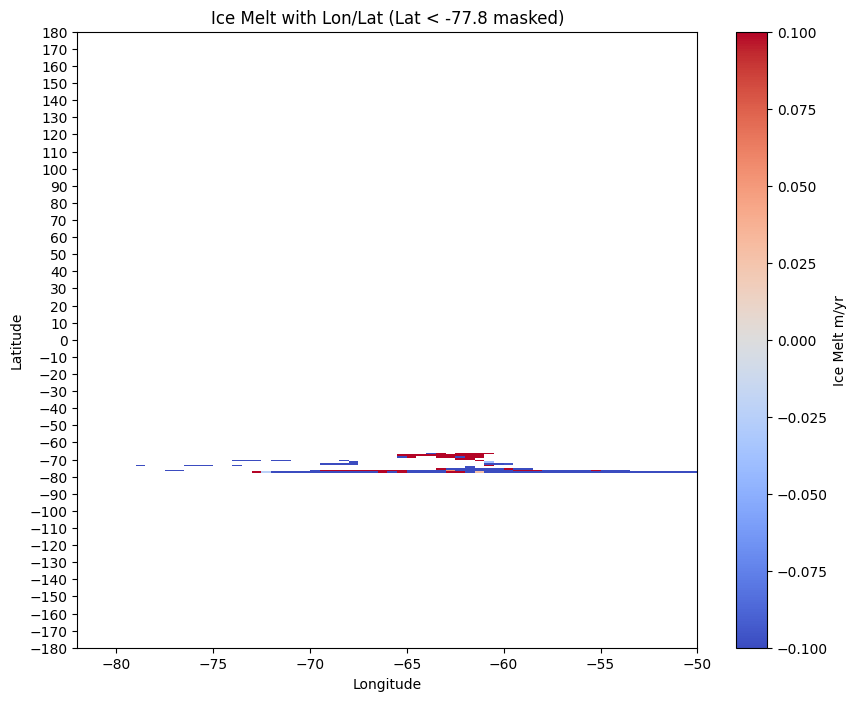

In [112]:
plt.figure(figsize=(10, 8))
plt.pcolormesh(
    regridded_ice_vels_melt["lon"],
    regridded_ice_vels_melt["lat"],
    regridded_ice_vels_melt['melt_vel'].isel(time=30),  # Plot the melt data at time step 30
    cmap="coolwarm",
    shading="auto",
    vmin=-0.1,
    vmax=0.1
)
plt.colorbar(label="Ice Melt m/yr")
plt.title("Ice Melt with Lon/Lat (Lat < -77.8 masked)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Adjust y-axis ticks
plt.gca().yaxis.set_major_locator(MultipleLocator(10))

# Show the plot
plt.show()

In [113]:
# Check for NaN values in selected_SSH and selected_ice_vels['melt']
print(f"NaN values in selected_SSH: {selected_SSH.isnull().sum()}")
print(f"NaN values in selected_ice_vels: {np.isnan(regridded_selected_ice_vels).sum()}")



NaN values in selected_SSH: <xarray.DataArray 'SSH' ()> Size: 8B
array(0)


NameError: name 'regridded_selected_ice_vels' is not defined

In [441]:
print(ice_vels_nan_mask)

<xarray.DataArray 'melt_vel' (lat: 360, lon: 64)> Size: 23kB
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Coordinates:
    time     datetime64[ns] 8B 2002-09-16T10:04:48.000003584
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25


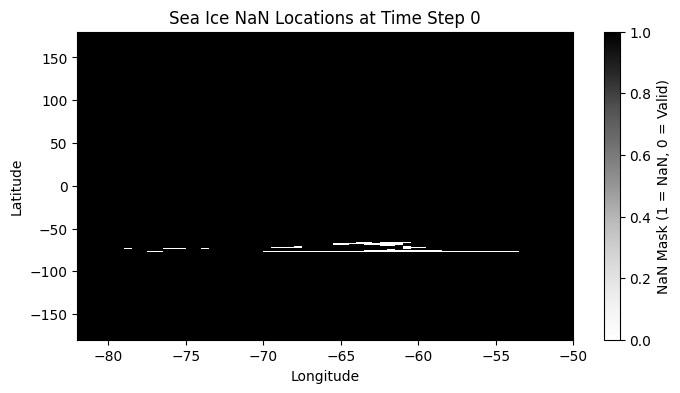

In [442]:
#plot where there are nan values (this is where i created the mask for SIC > 1 earlier)
time_step = 0
# Create a mask where NaN values are True
ice_vels_nan_mask = np.isnan(regridded_ice_vels_melt['melt_vel'].isel(time =time_step))

lon_mesh, lat_mesh = np.meshgrid(target_lons, target_lats)

# Plot the mask using pcolormesh
plt.figure(figsize=(8, 4))
plt.pcolormesh(
    lon_mesh, lat_mesh, ice_vels_nan_mask,
    cmap='Greys', shading='auto'
)


plt.colorbar(label='NaN Mask (1 = NaN, 0 = Valid)')
plt.title(f"Sea Ice NaN Locations at Time Step {time_step}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


(61, 64, 360)


In [280]:
model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))

# model.fit(dot_masked_ds['SSH'], WSC_eumetsat_ds['WSC'], dim='time')
model.fit(selected_SSH, selected_ice_vels, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)
s1 = scores1.values;
s2 = scores2.values
c1 = comps1.values;
c2 = comps2.values

#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...
r_pears = [];
p_pears = []
r_spear = [];
p_spear = []
for m in range(1, 5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2));
    p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2));
    p_spear.append(np.round(p, 2))
fig = plt.figure(figsize=(12, 10))

for i in range(0, 4):
    j = 3 * i + 1  # a = 2*(i+1) + i - 1

    plt.subplot(4, 3, j)
    scores1.sel(mode=i + 1).plot(label='SSH')
    scores2.sel(mode=i + 1).plot(label='Ice melt velocity')
    plt.title('r = ' + str(r_spear[i]))
    plt.xlabel('Year');
    plt.ylabel('PC' + str(int(i + 1)))
    plt.xticks(rotation=30)
    plt.legend()

    plt.subplot(4, 3, j + 1)
    comps1.sel(mode=i + 1).plot()
    plt.title('SSH')

    plt.subplot(4, 3, j + 2)
    comps2.sel(mode=i + 1).plot()
    plt.title('Ice melt velocity')

fig.tight_layout()

#fig.savefig(path + 'results/MCA_output_' + gridtype + '_seas.png')
# compute squared covariance fraction (equivalent to explained variance in PCA)
sq_cov_frac = model.squared_covariance_fraction()
scf = sq_cov_frac.values
cum_sum = np.cumsum(scf)
print('Cumulative sum of squares:', cum_sum)
print('Squared covariance fraction:', scf)
print(type(cum_sum))
print(len(cum_sum))
mode_percent = []
for i in range(len(cum_sum)):
    if i == 0:
        each_mode_percent = float(cum_sum[i])
        mode_percent.append(each_mode_percent)
    else:
        each_mode_percent = float(cum_sum[i] - cum_sum[i - 1])
        mode_percent.append(each_mode_percent)
print('PCA fraction', mode_percent)

ValueError: Input data contains partial NaN entries, which will cause the the SVD to fail.